In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import seaborn as sns          
import matplotlib.pyplot as plt             
import cv2
from PIL import Image 
import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Input,Flatten
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files as fp



In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from pathlib import Path
#dataset_Video=pd.read_csv('./drive/MyDrive/SampleFolderforTags/features (2).csv')
trainPathMode='./drive/MyDrive/Train/' # Training data for Separate folders with features names
testPathmode='./drive/MyDrive/Test/' # test data to evaluate the model
validatePathmode='./drive/MyDrive/Validation/' # validation data to evaluate the model during training
explicit_data='./drive/MyDrive/trialImages/' # The folder has images that are not being used in train,validation,test data . 
#The explicit data are created after passing the any new video through the keyframe codes 




# Image data generator for data augmentation for train,test,validate data
# Rescaling ,Flipping,Rotating the  image data to capture its properties
trainAugment =ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.3,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
validateAugment=ImageDataGenerator(rescale=1./255)

In [ ]:
valid_generator=validateAugment.flow_from_directory(
    validatePathmode,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=16,
    shuffle=True,
    )

Found 421 images belonging to 2 classes.


In [ ]:
train_generator=trainAugment.flow_from_directory(
    trainPathMode,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=16,
    shuffle=True
    )

Found 1679 images belonging to 2 classes.


In [ ]:
# Test data augmentation and generation
testAugment=ImageDataGenerator(rescale=1./255)
test_generator=testAugment.flow_from_directory(
    testPathmode,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=16,
    shuffle=False
    )

Found 597 images belonging to 2 classes.


In [ ]:
# Preparing the dataframe containing training data information
imgname=[]
fname=[]
filenames=train_generator.filenames
for i in range(len(filenames)):
  targets=filenames[i].split("/")
  imgname.append(targets[1])
  fname.append(targets[0])
trainset_details=pd.DataFrame()
trainset_details["ImageName"]=imgname
trainset_details["Feature"]=fname

In [ ]:
# Features in the dataset
features_name=trainset_details["Feature"].unique()
print(features_name)

['Digital_Pen' 'Handwritten']


Image with size ( 100 X 100 )


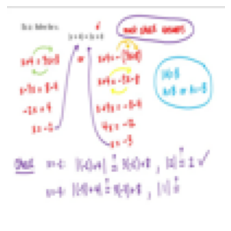

Image with size ( 150 X 150 )


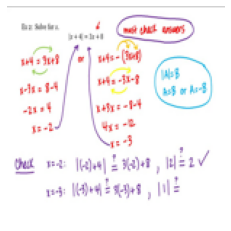

Image with size ( 200 X 200 )


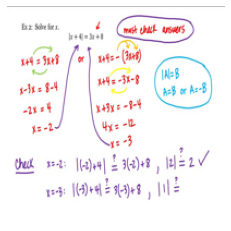

Image with size ( 224 X 224 )


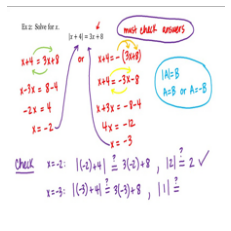

Image with size ( 256 X 256 )


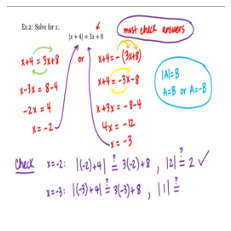

Image with size ( 512 X 512 )


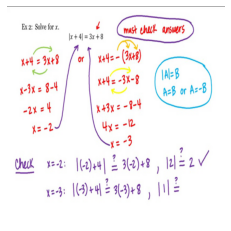

In [ ]:
# sample of one data with various resizing
select_file=trainPathMode+train_generator.filenames[3]
for i in [100,150,200,224,256,512]:
    rgba_image = Image.open(select_file)
    resized=rgba_image.resize((i,i))
    print("Image with size (",i,"X",i,")")
    plt.imshow(resized)
    plt.axis("off")
    plt.show()
   

In [ ]:
#Using resnet base from keras
baseModel=tf.keras.applications.InceptionV3(
    include_top=False,
     weights="imagenet",
    input_tensor=Input(shape=(224,224,3))
)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# 
for bl in baseModel.layers:
    bl.trainable=False

In [ ]:
# Model defination for the classification
headModel=baseModel.output
headModel=MaxPooling2D(pool_size=(3,3))(headModel)
headModel=Dense(512,activation="relu")(headModel)
headModel=Dropout(rate=0.1)(headModel)
headModel=Dense(256,activation="relu")(headModel)
headModel=Dense(128,activation="relu")(headModel)
headModel=Flatten(name="flatten")(headModel)
headModel=Dropout(rate=0.6)(headModel)
headModel=Dense(2,activation="softmax")(headModel)

In [ ]:
model=Models.Model(inputs=baseModel.input,outputs=headModel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#Model compilation for training
model.compile(loss="categorical_crossentropy",optimizer=Optimizer.Adam(learning_rate=0.001),metrics=['accuracy','Precision'])

In [ ]:
# Fitting the data into the model for training
model.fit(train_generator,steps_per_epoch=len(train_generator.filenames)//16, validation_data=valid_generator,validation_steps=len(valid_generator.filenames)//16,epochs=20)

Epoch 1/20
104/104 [==============================] - 919s 9s/step - loss: 1.0727 - accuracy: 0.7457 - precision: 0.7457 - val_loss: 0.0676 - val_accuracy: 0.9856 - val_precision: 0.9856
Epoch 2/20
104/104 [==============================] - 188s 2s/step - loss: 0.1277 - accuracy: 0.9584 - precision: 0.9584 - val_loss: 0.0807 - val_accuracy: 0.9808 - val_precision: 0.9808
Epoch 3/20
104/104 [==============================] - 173s 2s/step - loss: 0.0882 - accuracy: 0.9643 - precision: 0.9643 - val_loss: 0.1350 - val_accuracy: 0.9567 - val_precision: 0.9567
Epoch 4/20
104/104 [==============================] - 173s 2s/step - loss: 0.1255 - accuracy: 0.9584 - precision: 0.9584 - val_loss: 0.0696 - val_accuracy: 0.9784 - val_precision: 0.9784
Epoch 5/20
104/104 [==============================] - 172s 2s/step - loss: 0.1010 - accuracy: 0.9767 - precision: 0.9767 - val_loss: 0.0433 - val_accuracy: 0.9832 - val_precision: 0.9832
Epoch 6/20
104/104 [==============================] - 178s 2s/ste

In [ ]:
test_score=model.evaluate(test_generator)

38/38 [==============================] - 271s 7s/step - loss: 0.0359 - accuracy: 0.9899 - precision: 0.9899


In [ ]:
scores=pd.DataFrame(zip(model.metrics_names,test_score))
print(scores) # Metrics of Test scores from Model evaluation

           0         1
0       loss  0.035897
1   accuracy  0.989950
2  precision  0.989950


In [ ]:
predictions=model.predict(test_generator) # Model prediction over the test data

In [ ]:
print("Total number of prediction is ", len(predictions))

Total number of prediction is  597


In [ ]:
#
pred_values=[]
for i in range(len(predictions)):
  pred_values.append(features_name[np.argmax(predictions[i])])
act_values=[]
tname=[]
filenames_test=test_generator.filenames
for i in range(len(filenames_test)):
  targets=filenames_test[i].split("/")
  act_values.append(targets[0])
  tname.append(targets[1])



In [ ]:
# Final prediction Dataframe
final_prediction=pd.DataFrame()
final_prediction["ImageName"]=tname
final_prediction["Actual Feature"]=act_values
final_prediction["Predicted Feature"]=pred_values


In [ ]:
exp_images=[]
exp_data_filename=[]
for i in os.listdir(explicit_data):
     # Reading the image
     exp_data_filename.append(i)
     img =cv2.imread(explicit_data+"//"+i)
     # Normalization of images of training data 
     image = cv2.resize(img,(224,224))
     imagef=cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
     exp_images.append(imagef)


In [ ]:
pred_on_exp_data=model.predict(np.array(exp_images))

In [ ]:
exp_pred_values=[]
for i in range(len(pred_on_exp_data)):
  exp_pred_values.append(features_name[np.argmax(pred_on_exp_data[i])])
exp_outcome=pd.DataFrame()
exp_outcome["ImageName"]=exp_data_filename
exp_outcome["Predicted Feature"]=exp_pred_values

In [ ]:
exp_outcome["Predicted Feature"].value_counts()

Digital_Pen    1168
Handwritten     140
Name: Predicted Feature, dtype: int64

In [ ]:
# Final prediction output
final_prediction.to_csv("Prediction.csv")
fp.download('Prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Traning data output
trainset_details.to_csv("Traning_set_info.csv")
fp.download('Traning_set_info.csv')